In [1]:
import lightkurve as lk
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
df = pd.read_csv('/Users/tuca/Desktop/EPIC_exoplanet_research_2023/detrended_lc.csv', header = 0,
                 names = ['time', 'flux', 'flux_error', 'Kepler'])
df

,time,flux,flux_error,Kepler
0,2.457218e+06,0.999964,0.000349,Kepler
1,2.457218e+06,0.999885,0.000349,Kepler
2,2.457218e+06,0.999775,0.000350,Kepler
3,2.457218e+06,1.000145,0.000350,Kepler
4,2.457218e+06,1.000182,0.000350,Kepler
...,...,...,...,...
6774,2.458247e+06,1.000329,0.000256,Kepler
6775,2.458247e+06,0.999761,0.000256,Kepler
6776,2.458247e+06,0.999960,0.000256,Kepler
6777,2.458247e+06,0.999999,0.000256,Kepler


In [3]:
time = (df['time'] - 2454833).values
flux = df['flux'].values
flux_error = df['flux_error'].values

2384.503430427052


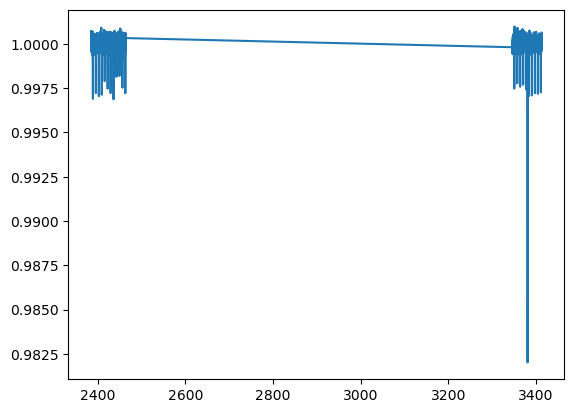

In [4]:
plt.plot(time, flux)
print(np.min(time))
# plt.xlim(2300, 2500)
# plt.ylim(0.9975, 1.0)

In [5]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import starry
import pdb
from astropy import constants as const
from astropy import units as u

In [152]:
periods = [6.7252337648, 600]
period_error = [0.01, 100]
t0s = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833] #[2388.835, 3380.822]
t0_error = [0.01, 0.2]
duration = [0.9/24, 15.71/24]
nplanets = 2
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88
ecc_fit = False

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((const.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (const.R_sun).to(u.au).value

#pdb.set_trace()

with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma=10.0)
    ustar = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    # Stellar parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
    m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
    r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
    teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
    st_lum = pm.Deterministic("st_lum", (r_star**2) * ((teff/5777)**4)) #stellar luminosity #derived parameter
    star_params = [mean, ustar] 
    
    # Planet parameters
    ror = pm.Uniform("ror", lower=0.01, upper = 1, shape=nplanets, testval=np.array([0.04, 0.06]))
    r_pl = pm.Deterministic("r_pl", ror*r_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step
    m_pl = pm.Uniform("m_pl", lower=0.1, upper=3e6, testval=Expected_msini, shape=nplanets)
    # deterministic means values that were derived from the model
    density_pl = pm.Deterministic("density_pl", m_pl/((r_pl*Rsun2Rearth)**3) * 5.514) # Convert from rho_earth to g/cm3

    # Orbital parameters
    period = pm.Normal("period", mu=periods, sigma= np.array(period_error), shape=nplanets)
    t0 = pm.Normal("t0", mu=t0s, sigma=np.array(t0_error), shape=nplanets)
    b = xo.distributions.ImpactParameter("b", ror=ror, shape=nplanets)
    
    # Set up the orbit
    #orbit = xo.orbits.KeplerianOrbit(period=period, ror = ror, duration=dur, t0=t0, b=b)

    if ecc_fit:
        # for an eccentric orbit # 
        ecs = pmx.UnitDisk("ecs", testval=np.array([[0.1, 0.1]] * nplanets).T, shape=(2, nplanets))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    else:
        # for circular orbit #
        ecc = np.repeat(0, nplanets)
        omega = np.repeat(np.pi/2, nplanets)

    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(r_star = r_star, m_star= m_star, period = period, t0 = t0, b = b, 
                                     ecc = ecc, omega = omega)
    #m_planet = xo.units.with_unit(m_pl, u.M_earth)
    
    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(ustar[0], ustar[1])

    light_curves = star.get_light_curve(texp = 29.4*u.min.to('d'), orbit=orbit, r=r_pl, t=time) #calculate lc for each planet at its time vector
    lc_model = mean + tt.sum(light_curves, axis=-1) #full photometric model, the sum of all transits + the baseline (mean)
    
    pm.Deterministic("light_curves", light_curves) #saves the individual lightcurves
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=lc_model, sd=flux_error, observed=flux)
    
    map_soln = model.test_point
    print(model.check_test_point())
    map_soln = pmx.optimize(map_soln, [ror, b])
    map_soln = pmx.optimize(map_soln, [t0, period])
    map_soln = pmx.optimize(map_soln, [ror, b, t0, period])
    

    map_soln = pmx.optimize(map_soln)
    
#     map_soln = pmx.optimize(map_soln, [r_pl, b, dur])
#     map_soln = pmx.optimize(map_soln, star_params)


#     ####################################################################################  


    # Orbital parameters
    # 'log period' is normally used when you dont know the period of the planet 
#     log_period = pm.Normal("log_period", mu=np.log(periods), sigma=1.0, shape = nplanets) #free parameter is log period
#     period = pm.Deterministic("period", tt.exp(log_period))
#     t0 = pm.Normal("t0", mu=t0s, sigma=1.0, shape = 2)
#     log_dur = pm.Normal("log_dur", mu=np.log(duration), sigma=10.0, shape = nplanets)
#     dur = pm.Deterministic("dur", tt.exp(log_dur))
    

mean                -3.220000e+00
u_quadlimbdark__    -3.230000e+00
m_star_interval__   -1.120000e+00
r_star_interval__    1.000000e-02
teff_interval__     -7.100000e+00
ror_interval__      -6.560000e+00
m_pl_interval__     -3.004000e+01
period              -1.840000e+00
t0                   4.380000e+00
b_impact__          -2.780000e+00
obs                 -3.790713e+10
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [b, ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -37907128140.01031 -> -37904021929.427
optimizing logp for variables: [period, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -37904021929.427 -> -37904021929.329475
optimizing logp for variables: [period, t0, b, ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -37904021929.329475 -> -37904021929.329475
optimizing logp for variables: [b, t0, period, m_pl, ror, teff, r_star, m_star, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -37904021929.329475 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


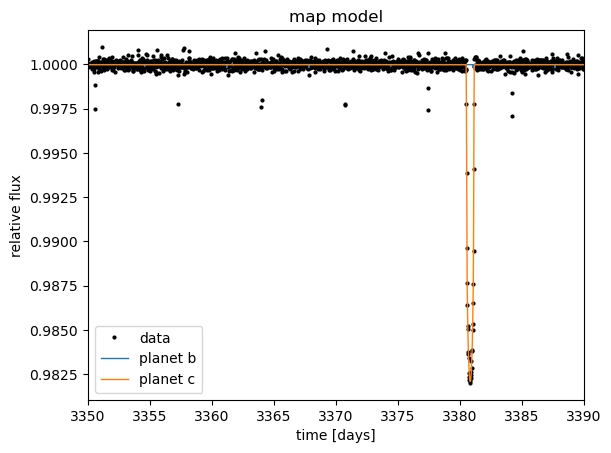

In [151]:
plt.plot(time, flux, ".k", ms=4, label="data")

for i, l in enumerate("bc"):
    plt.plot(
        time, map_soln["light_curves"][:,i]+map_soln["mean"], lw=1, label="planet {0}".format(l)
    )
plt.xlim(time.min(), time.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3390)
plt.legend(fontsize=10)
_ = plt.title("map model")

In [156]:
print(map_soln['period'])
print(map_soln['t0'])
print(map_soln["ror"])

print(map_soln['b'])
print(map_soln['m_star'])
print(map_soln['r_star'])

[  6.7240074  599.99903883]
[2388.83467218 3380.79766667]
[0.0464627  0.06018372]
[1.04639748 1.06005107]
0.75
0.75


In [106]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=5000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, t0, period, m_pl, ror, teff, r_star, m_star, u, mean]


/Users/tuca/Documents/EPIC/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tuca/Documents/EPIC/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 381 seconds.
There were 3409 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3379 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [108]:
import arviz as az

az.summary(trace, var_names=["period", "t0", "ror", "b", "u", "mean"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period[0],6.725,0.000,6.725,6.725,0.000,0.000,2632.0,2647.0,1.00
period[1],1749.440,578.553,996.708,2791.750,18.776,13.280,844.0,1535.0,1.00
t0[0],2388.835,0.001,2388.833,2388.836,0.000,0.000,2058.0,2424.0,1.00
t0[1],3380.812,0.000,3380.812,3380.812,0.000,0.000,2068.0,1592.0,1.00
ror[0],0.324,0.304,0.046,0.898,0.015,0.011,269.0,541.0,1.01
ror[1],0.012,0.001,0.010,0.014,0.000,0.000,728.0,683.0,1.00
b[0],1.195,0.361,0.729,1.898,0.019,0.014,272.0,523.0,1.01
b[1],0.901,0.077,0.767,1.014,0.003,0.002,878.0,768.0,1.00
u[0],0.948,0.509,0.030,1.739,0.012,0.008,1830.0,2172.0,1.00
u[1],-0.158,0.456,-0.904,0.680,0.010,0.007,2009.0,1901.0,1.00


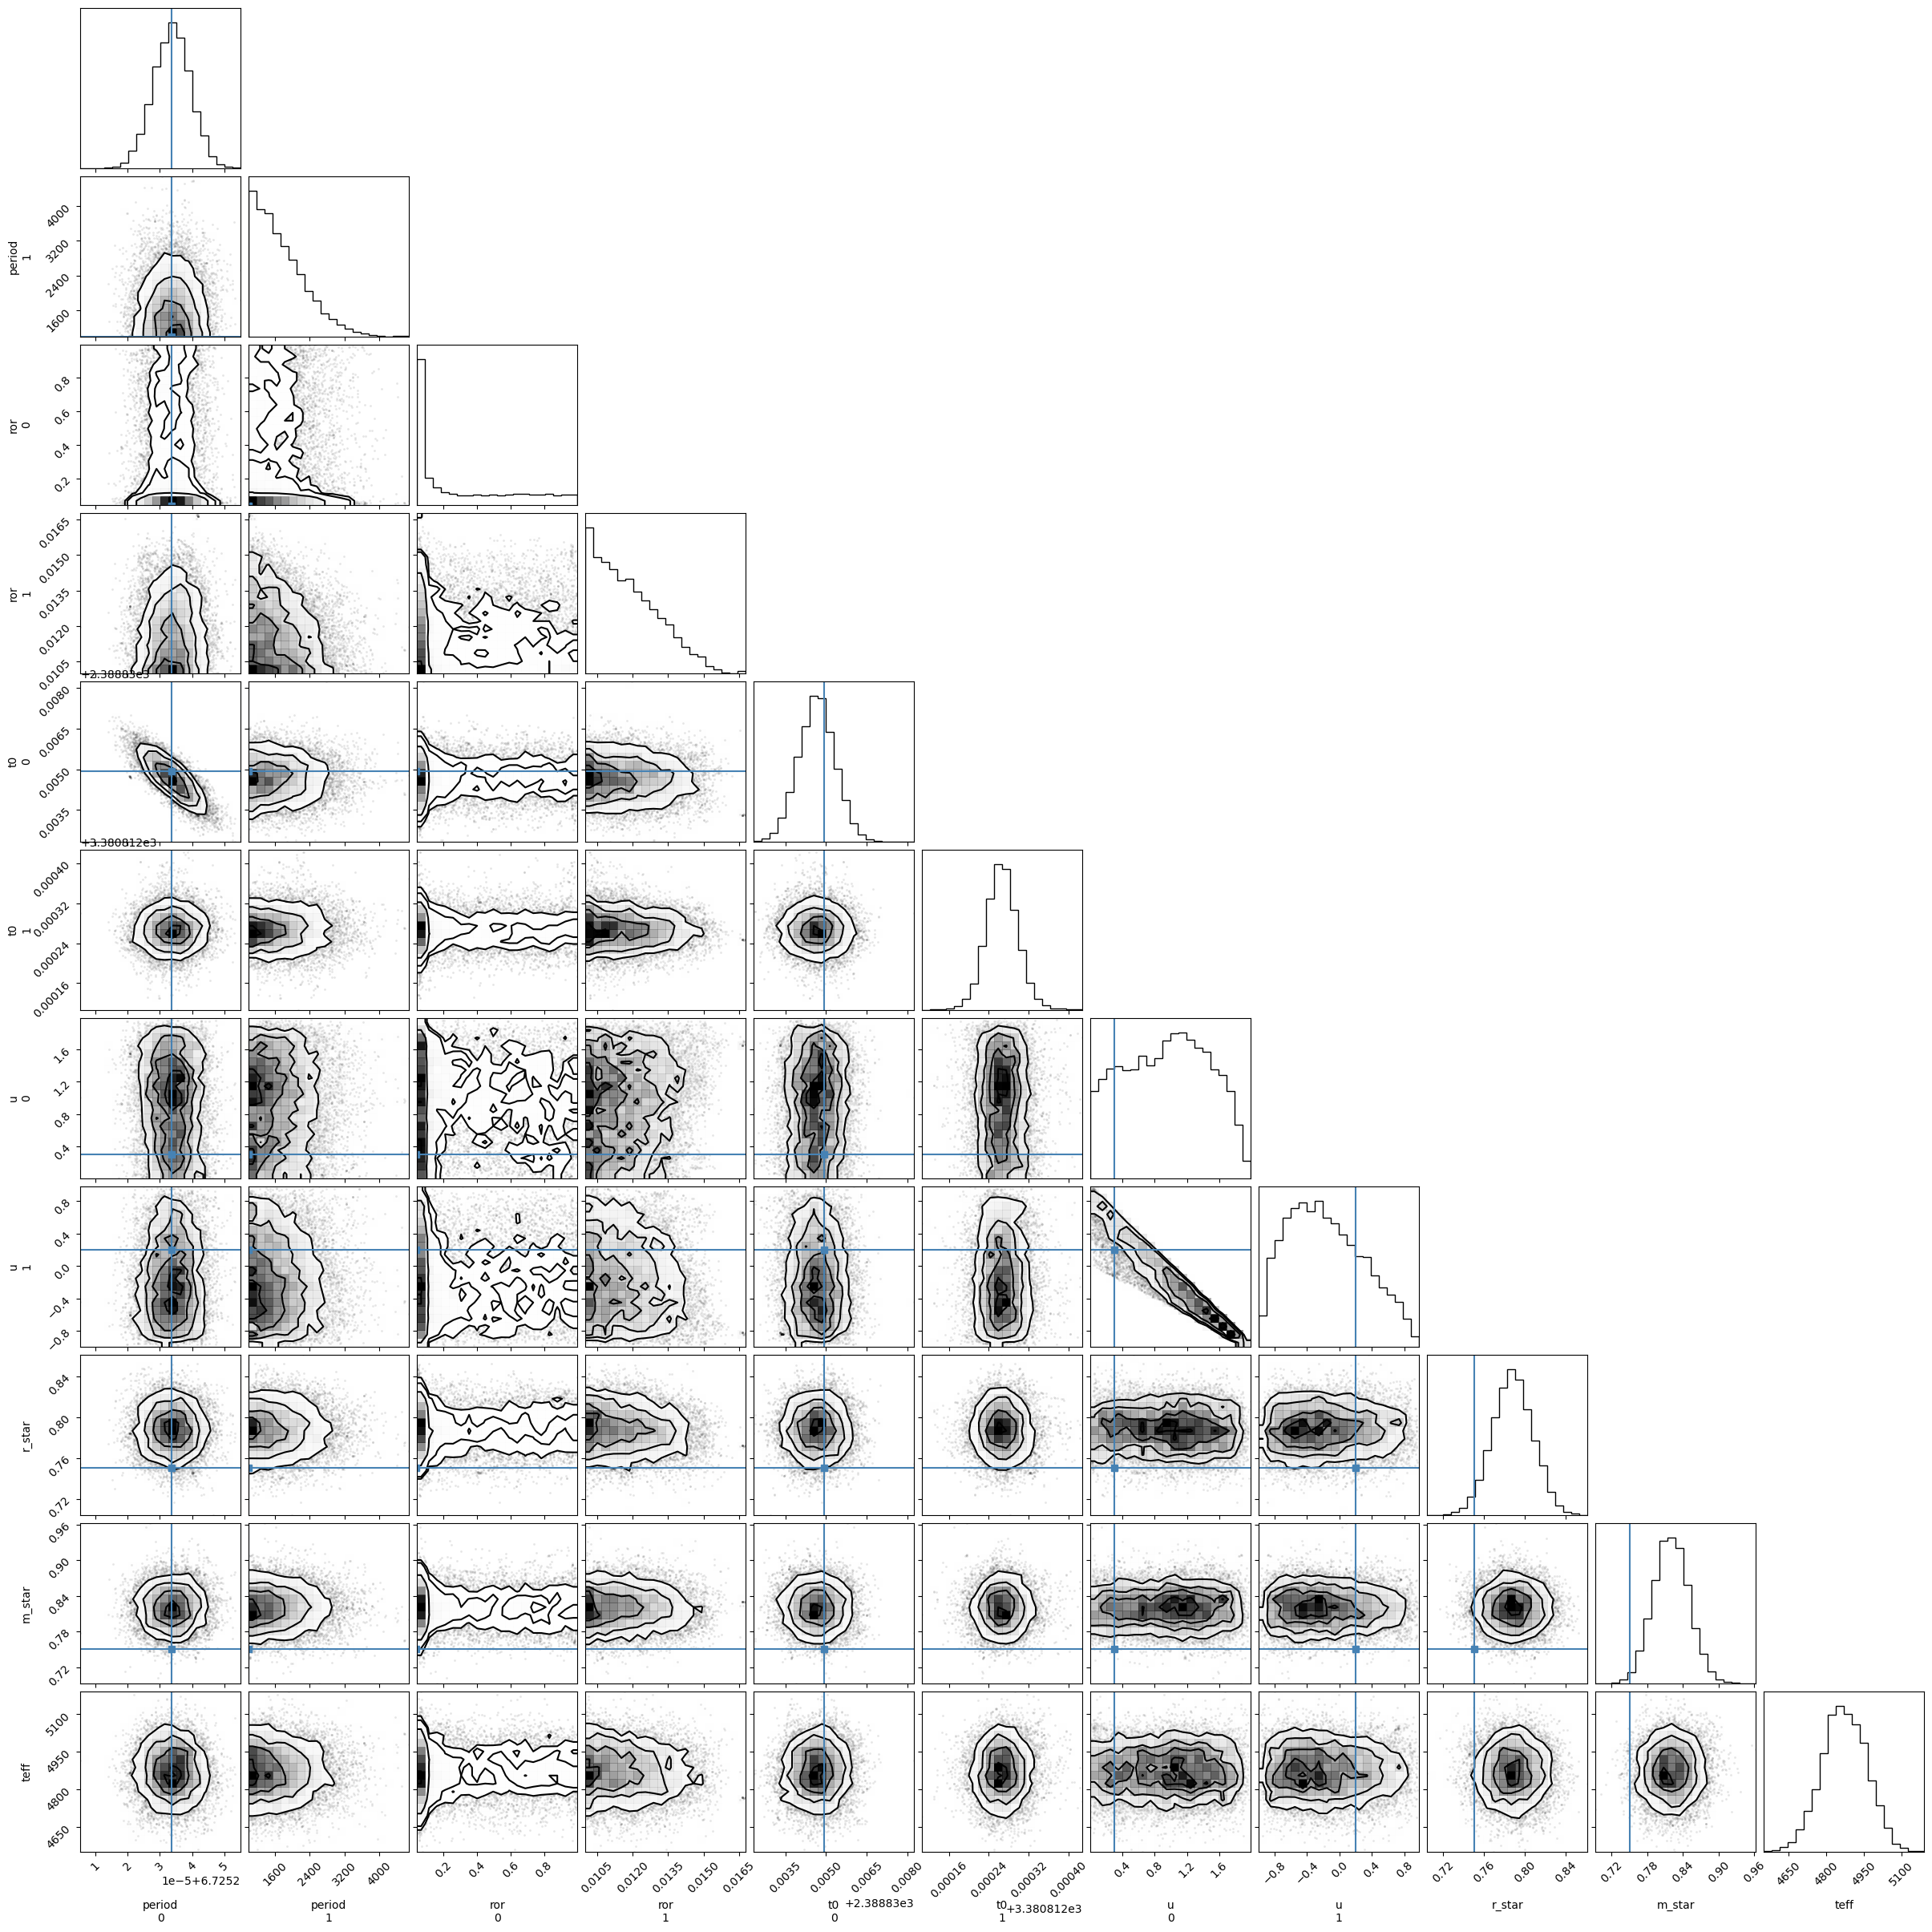

In [111]:
import corner

truth = dict(
    zip(
        ["period", "ror", "t0", "u", "r_star", "m_star", "teff"],
        pmx.eval_in_model([period, ror, t0, ustar, r_star, m_star, teff], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["period", "ror", "t0", "u", "r_star", "m_star", "teff"],
    truths=truth,
)

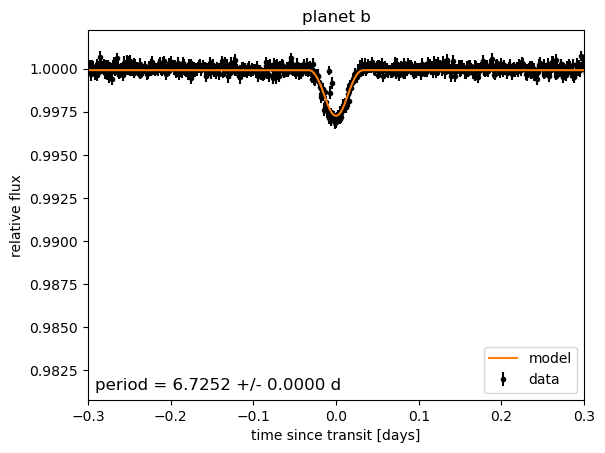

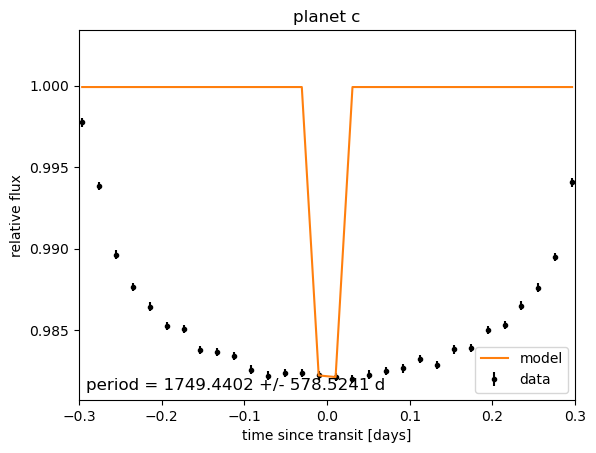

In [112]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    period_trace = trace.posterior["period"].values[:, :, n]
    p = np.median(period_trace)
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    lcs = trace.posterior["light_curves"].values
    other = np.median(lcs[:, :, :, (n + 1) % 2], axis=(0, 1))

    # Plot the folded data
    x_fold = (time - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, flux - other, yerr=flux_error, fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = lcs[:, :, inds, n] + trace.posterior["mean"].values[:, :, None]
    pred = np.median(pred, axis=(0, 1))
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(period_trace), np.std(period_trace)
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

In [99]:
print(map_soln['period'])
print(map_soln['t0'])
print(map_soln["ror"])

print(map_soln['b'])

[6.72523376e+00 9.99730526e+04]
[2388.83491849 3380.81285747]
[0.21132248 0.99998048]
[1.14900588 0.33048598]


In [88]:
print(map_soln["ror"])
print(map_soln['period'])
print(map_soln['t0'])
print(map_soln['b'])

[0.04 0.06]
[   6.59713434 -766.42872173]
[2388.80705932 3380.70662545]
[0.5 0.5]


In [10]:
#     # The baseline flux
#     mean = pm.Normal("mean", mu=0.0, sd=10.0)

#     # The time of a reference transit for each planet
#     t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

#     # The log period; also tracking the period itself
#     logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
#     period = pm.Deterministic("period", pm.math.exp(logP))

#     # The Kipping (2013) parameterization for quadratic limb darkening paramters
#     # Stellar Parameters
#     u = xo.distributions.QuadLimbDark("u")

#     r = pm.Uniform("r", lower=0.01, upper=0.1, shape=2)
    
#     b = xo.distributions.ImpactParameter(
#         "b", ror=r, shape=2)


#     # Set up a Keplerian orbit for the planets
#     orbit = xo.orbits.KeplerianOrbit(period=period, t=t0, b=b)

#     # Compute the model light curve using starry
#     light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
#         orbit=orbit, r=r, t=time
#     )
#     light_curve = pm.math.sum(light_curves, axis=-1) + mean
#     lc_model = mean + 1e3 * tt.sum(
#         light_curves.get_light_curve(orbit=orbit, r=ror, t=x), axis=-1
#     )

#     # Here we track the value of the model light curve for plotting
#     # purposes
#     pm.Deterministic("light_curves", light_curves)

#     # Fit for the maximum a posteriori parameters given the simuated
#     # dataset
# #     map_soln = pmx.optimize(start=model.test_point)
#     print(model.check_test_point())

In [11]:
with model:
    lc_pred = pmx.eval_in_model(lc_model, map_soln)
    #gp_pred = pmx.eval_in_model(gp.predict(y - lc_pred), map_soln)

plt.figure(figsize=(8, 4))
x_fold = (time - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
    "period"
] - 0.5 * map_soln["period"]
inds = np.argsort(x_fold)
plt.scatter(x_fold, y - gp_pred - map_soln["mean"], c=time, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["mean"], "k")
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

ValueError: operands could not be broadcast together with shapes (6779,) (2,) 

<Figure size 800x400 with 0 Axes>

In [ ]:
# ##### Planet 1 has t0 = 2457221.8349184883, per = 6.7252337648 days, duration of 0.9 hours. #####
# #### Planet 2 has t0 = 2458213.8222186137, duration of 15.71 hours and an unknown ####
# ##### period (so you can use per = 1000 when searching for all events). ######

# ###Using the EVEREST pipeline (K2/Campaign 17) ###

# #def mask_outliers(min_time, flux, flux_err, period = None, transit_time = None, duration = None):
# plt.rcParams['figure.figsize'] = [10, 5]
# lc = flux
# def mask_outliers(period, transit_time, duration):

#     mask_transit_1 = lc.create_transit_mask(period = period, transit_time = transit_time, duration = duration)
#     mask_transit_2 = lc.create_transit_mask(period = period, transit_time = transit_time, duration = duration)
#     mask_transit = mask_transit_1 | mask_transit_2
    
#     ### Numpy function that will return the NOT elements of mask_transit
#     ### Note: This is a logical function that computes the truth value of NOT arr element-wise ###
#     mask_out_transit = np.logical_not(mask_transit_1 | mask_transit_2)
    
#     ### Function that removes outliers in the data ###
#     mask_outliers = lc.remove_outliers(sigma_lower=10, sigma_upper=3)
    
#     #plotting the raw data out of transit data
#     plt.plot(lc.time.value[mask_out_transit], (lc.flux.value/np.median(lc.flux.value))[mask_out_transit], 
#                           'r.', linestyle='none', zorder = 0)
#     #plotting the mask_outliers function
#     plt.plot(mask_outliers.time.value, (mask_outliers.flux.value/np.median(mask_outliers.flux.value)), 
#                           'k.', linestyle='none', zorder = 10)
#     #plotting the in-transit points
#     plt.plot(lc.time.value[mask_transit], (lc.flux.value/np.median(lc.flux.value))[mask_transit], 
#                           'g.', linestyle='none', zorder = 2)

#     return mask_outliers
    
#     ### Note: The lightkurve function 'remove_outliers' by default uses np.median ###
#     ### and Caleb recommends to use a rolling median instead ###

#     ### To do:
#     ### 1. Modify this function by adding a mask and rolling median or wotan
#     ### 2. Try plotting TOI-1728

In [ ]:
# ### Calling the above function ###
# mask_outliers(period = [6.7252337648, 1e4], transit_time = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833], 
#               duration = [0.9/24, 15.71/24])
# #plt.xlim(3380, 3382)
# plt.ylim(0.98,1.01)